# Run Ensemble Mean upon Anemoi Models
Connecting cascade and anemoi allows for distributed and managed execution of models, and generation of products.

In [1]:
import anemoicascade as ac

In [2]:
import os

# Setup Environment
os.environ['PYTORCH_CUDA_ALLOC_CONF']='expandable_segments:True'
os.environ['LD_LIBRARY_PATH'] = f"INSERT_LD_LIBRARY_PATH_HERE:{os.environ['LD_LIBRARY_PATH']}"

## Additional cascade actions
`pproc-cascade` provides an action api for advanced production generation, but depends on pproc

In [3]:
from cascade import Cascade
import earthkit.data as ekd

PPCASCADE_IMPORTED = True
try:
    from ppcascade import fluent as ppfluent
except (RuntimeError, ImportError, AttributeError) as e:
    print('pproc cascade could not be imported', e)
    PPCASCADE_IMPORTED = False

pproc cascade could not be imported module 'earthkit.data.sources.array_list' has no attribute 'ArrayFieldList'


In [4]:
CKPT = "/lus/h2resw01/hpcperm/ecm0672/pub/anemoi-ckpt/inference-aifs-0.2.1-anemoi.ckpt"

With the environment ready, and the ckpt established, we can begin to call a prediction

In [5]:
ac.fluent.from_input?

Signature:
ac.fluent.from_input(
    ckpt: 'os.PathLike',
    input: 'str | dict[str, Any]',
    date: 'str | tuple[int, int, int]',
    lead_time: 'Any',
    *,
    ensemble_members: 'int' = 1,
    **kwargs,
) -> 'fluent.Action'
Docstring:
Run an anemoi model from a given input source

Parameters
----------
ckpt : os.PathLike
    Checkpoint to load
input : str | dict[str, Any]
    `anemoi.inference` input source.
    Can be `mars`, `grib`, etc or a dictionary of input configuration
date : str | tuple[int, int, int]
    Date to get initial conditions for
lead_time : Any
    Lead time to run out to. Can be a string, 
    i.e. `1H`, `1D`, int, or a datetime.timedelta
ensemble_members : int, optional
    Number of ensemble members to run, by default 1

Returns
-------
fluent.Action
    Cascade action of the model results

Examples
-------
>>> from anemoicascade import from_input
>>> from_input("anemoi_model.ckpt", "mars", date = "2021-01-01T00:00:00", lead_time = "10D")
File:      /etc/ec

All that is needed to run a prediction is the:
- checkpoint
- the input_type
- Start time
- Lead time

From there, the number of ensembles can be set, which is automatically added as a dimension

Note:
    Some issues do occur with running out of memory at higher ensemble numbers

In [6]:
model_action = ac.fluent.from_input(CKPT, 'mars', '2022-01-01T00:00', lead_time = '7D')
model_action

/etc/ecmwf/nfs/dh2_home_a/ecm1947/Projects/forecast-in-a-box/anemoi/anemoi-inference/src/anemoi/inference/legacy.py:20: UserWarning: Using legacy _legacy_variables_metadata, please try to patch your weights.
  warnings.warn(f"Using legacy {func.__name__}, please try to patch your weights.")
Environment validation failed. The following issues were found:
  python:
    Python version mismatch: 3.10.14 != 3.11.8
  mismatch:
    Version of module anemoi.utils was lower in training then in inference: 0.3.14.dev2+gb3dc864 <= 0.4.9
  uncommitted:
    Inference environment contains uncommited changes missing in training: anemoicascade
    Inference environment contains uncommited changes missing in training: anemoi.inference
    Inference environment contains uncommited changes missing in training: cascade
    Inference environment contains uncommited changes missing in training: earthkit.data


Now we can check the coordinates of the graph.

In [7]:
model_action.nodes.coords

Coordinates:
  * param    (param) object 128B 'cp' 'tp' 'sp' 'msl' '10u' ... 'z' 'u' 'v' 'w'
  * step     (step) int64 224B 6 12 18 24 30 36 42 ... 138 144 150 156 162 168
  * date     (date) <U16 64B '2022-01-01T00:00'
  * member   (member) int64 8B 0

In [8]:
if PPCASCADE_IMPORTED:
    from ppcascade.utils.window import Range
    
    interpolation = {
        "grid": "O320"
    }
    
    windows = [
                Range("0-24", [6, 12, 18, 24]), 
                Range("12-24", [12, 18, 24]), 
            ]


In [9]:
PRODUCT_CATALOG = {
    'ensemble_window_mean': lambda x: x.switch(ppfluent.Action).window_operation("mean", windows,dim="step", batch_size=2).ensemble_operation("mean", dim="ensemble_member"),
    'ensemble_mean': lambda x: x.select({'step':24}).mean(dim="member"),
}

In [10]:
graph = PRODUCT_CATALOG['ensemble_mean'](model_action)

With the ensemble mean for a bunch of the params chosen, we can visualise the graph

In [11]:
cascade_sel = Cascade.from_actions([graph])
cascade_sel.visualise("EnsembleMean.html", cdn_resources='in_line', preset='blob')

EnsembleMean.html


Now the fun part, execution...

In [12]:
%%time

from cascade.executors.dask import DaskLocalExecutor 

cascade_sel.executor = DaskLocalExecutor(memory_limit="24GB", n_workers=1, threads_per_worker=1)
results = cascade_sel.execute()

{'address': 'tcp://127.0.0.1:39387',
 'id': 'Scheduler-42eb9802-a19b-4b2a-96ce-e4cf6cd50f4a',
 'services': {'dashboard': 8787},
 'started': 1732738591.1296358,
 'type': 'Scheduler',
 'workers': {'tcp://127.0.0.1:32995': {'host': '127.0.0.1',
                                       'id': 0,
                                       'local_directory': '/dev/shm/_tmpdir_.ecm1947.38651075/dask-scratch-space/worker-bma_xple',
                                       'memory_limit': 24000000000,
                                       'name': 0,
                                       'nanny': 'tcp://127.0.0.1:42223',
                                       'nthreads': 1,
                                       'resources': {},
                                       'services': {'dashboard': 34775},
                                       'status': 'init',
                                       'type': 'Worker'}}}


/etc/ecmwf/nfs/dh2_home_a/ecm1947/Projects/forecast-in-a-box/anemoi/anemoi-inference/src/anemoi/inference/legacy.py:20: UserWarning: Using legacy _legacy_data_request, please try to patch your weights.
  warnings.warn(f"Using legacy {func.__name__}, please try to patch your weights.")
/etc/ecmwf/nfs/dh2_home_a/ecm1947/Projects/forecast-in-a-box/anemoi/anemoi-inference/src/anemoi/inference/metadata.py:341: UserWarning: 🚧  TEMPORARY CODE 🚧: Use the remapping in the metadata
  warnings.warn("🚧  TEMPORARY CODE 🚧: Use the remapping in the metadata")
/etc/ecmwf/nfs/dh2_home_a/ecm1947/Projects/forecast-in-a-box/anemoi/anemoi-inference/src/anemoi/inference/metadata.py:341: UserWarning: 🚧  TEMPORARY CODE 🚧: Use the remapping in the metadata
  warnings.warn("🚧  TEMPORARY CODE 🚧: Use the remapping in the metadata")


All tasks completed successfully.
{'param': ('q', 't', 'u', 'v', 'w', 'z', 'sp', 'msl', '10u', '10v', '2t', '2d', 'skt', 'tcw', 'cp', 'tp'), 'step': (6, 12, 18, 24, 30, 36, 42, 48, 54, 60, 66, 72, 78, 84, 90, 96, 102, 108, 114, 120, 126, 132, 138, 144, 150, 156, 162, 168)}
MEAN: wall time: 0.0052528 s (5.2528 milliseconds), CPU time: 0.005143 s (5.143 milliseconds), memory: 10933518336 bytes (10.1826 GiB)
MEAN: wall time: 0.0690569 s (69.0569 milliseconds), CPU time: 0.062004 s (62.004 milliseconds), memory: 10933518336 bytes (10.1826 GiB)
MEAN: wall time: 0.0682169 s (68.2169 milliseconds), CPU time: 0.054878 s (54.878 milliseconds), memory: 10933518336 bytes (10.1826 GiB)
MEAN: wall time: 0.0708607 s (70.8607 milliseconds), CPU time: 0.067754 s (67.754 milliseconds), memory: 10933518336 bytes (10.1826 GiB)
MEAN: wall time: 0.0055368 s (5.5368 milliseconds), CPU time: 0.006951 s (6.951 milliseconds), memory: 10933518336 bytes (10.1826 GiB)
MEAN: wall time: 0.0106623 s (10.6623 millise

In [13]:
combined_data = ekd.from_source('multi', list(results.values()))

In [14]:
combined_data.ls()

,centre,shortName,typeOfLevel,level,dataDate,dataTime,stepRange,dataType,number,gridType
0,ecmf,10v,surface,0.0,20220101.0,0.0,24,an,0.0,reduced_gg
1,ecmf,v,isobaricInhPa,50.0,20220101.0,0.0,24,an,0.0,reduced_gg
2,ecmf,z,isobaricInhPa,50.0,20220101.0,0.0,24,an,0.0,reduced_gg
3,ecmf,q,isobaricInhPa,50.0,20220101.0,0.0,24,an,0.0,reduced_gg
4,ecmf,10u,surface,0.0,20220101.0,0.0,24,an,0.0,reduced_gg
5,ecmf,sp,surface,0.0,20220101.0,0.0,24,an,0.0,reduced_gg
6,ecmf,msl,surface,0.0,20220101.0,0.0,24,an,0.0,reduced_gg
7,ecmf,2d,surface,0.0,20220101.0,0.0,24,an,0.0,reduced_gg
8,ecmf,skt,surface,0.0,20220101.0,0.0,24,an,0.0,reduced_gg
9,ecmf,t,isobaricInhPa,50.0,20220101.0,0.0,24,an,0.0,reduced_gg


## Plotting

In [15]:
from earthkit.regrid import interpolate
import earthkit.plots as ekp
import earthkit.plots.quickmap as qmap

In [16]:
VAR_OF_INTEREST = '2t'

In [17]:
# the target grid is a global 5x5 degree regular latitude grid
out_grid = {"grid": [0.25,0.25]}
r = interpolate(combined_data.sel(param = VAR_OF_INTEREST), out_grid=out_grid, method="linear")

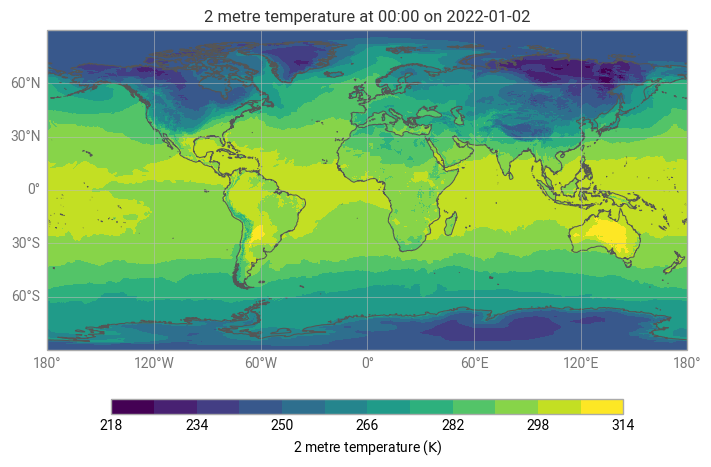

In [18]:
qmap.plot(r, colors = 'viridis')